In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings

# Data

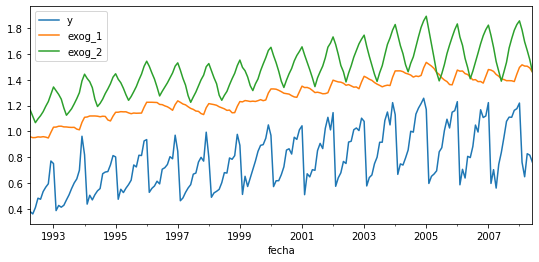

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoreg without exogenous variables

In [4]:
# Create and fit forecaster
# ==============================================================================
regressor = make_pipeline(StandardScaler(), Ridge())
lags = 15

forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags = lags
                )

forecaster.fit(y=data_train.y)
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2021-12-08 22:32:46 
Last fit date: 2021-12-08 22:32:46 
Skforecast version: 0.4.0 

Test error (mse): 0.010454411313511013


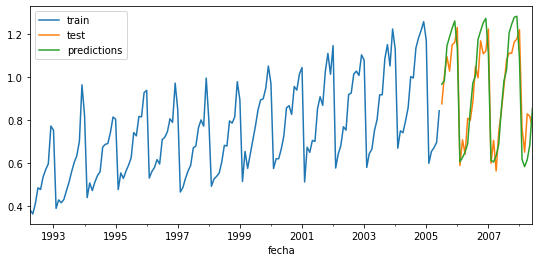

In [5]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [28]:
# Grid search hiperparameters and lags
# ==============================================================================

# Regressor hiperparameters
param_grid ={'ridge__alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = True,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  4.95it/s]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'ridge__alpha': 0.01}



,lags,params,metric,ridge__alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'ridge__alpha': 0.01},0.025726,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'ridge__alpha': 0.1},0.025732,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'ridge__alpha': 1},0.025815,1.00
6,"[1, 2, 3, 20]",{'ridge__alpha': 0.01},0.043819,0.01


In [7]:
# Predictors importance
# ==============================================================================
forecaster.get_coef()

,feature,coef
0,lag_1,0.128890
1,lag_2,-0.009212
2,lag_3,0.023736
3,lag_4,-0.020876
4,lag_5,-0.009362
5,lag_6,0.009474
6,lag_7,-0.027663
7,lag_8,0.013131
8,lag_9,0.011912
9,lag_10,0.053554


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[0.07671593]


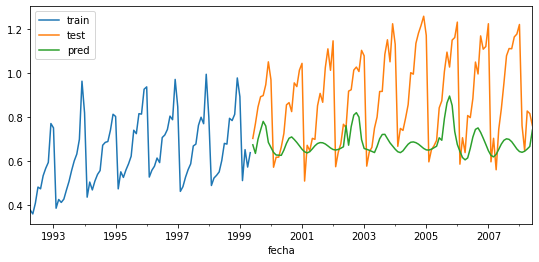

In [8]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
predicciones_backtest

,pred
1999-06-01,0.674855
1999-07-01,0.635930
1999-08-01,0.700172
1999-09-01,0.741751
1999-10-01,0.780962
...,...
2008-02-01,0.640887
2008-03-01,0.645681
2008-04-01,0.655776
2008-05-01,0.667460


In [10]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with 1 exogenous variables

In [11]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [12]:
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = lags
              )
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2021-12-08 22:24:41 
Last fit date: None 
Skforecast version: 0.4.0 

Test error (mse): 0.012636212003616849


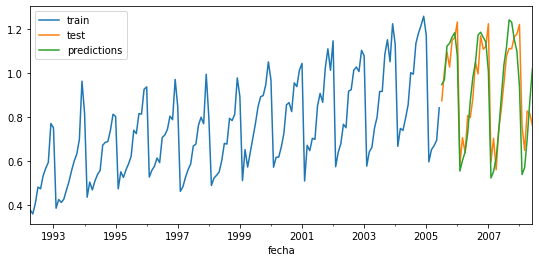

In [13]:
# Create and fit forecaster
# ==============================================================================
forecaster.fit(y=data_train.y, exog=data_train.exog_1)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [14]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor= make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'randomforestregressor__n_estimators': [50, 100],
              'randomforestregressor__max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = False,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


lo

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]

,lags,params,metric,randomforestregressor__max_depth,randomforestregressor__n_estimators
8,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 5, 'rando...",0.054931,5,50
10,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 10, 'rand...",0.057604,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'randomforestregressor__max_depth': 5, 'rando...",0.059934,5,50
9,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 5, 'rando...",0.060493,5,100


In [15]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=10)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[6.21996921e-30]


In [16]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with multiple exogenous variables

In [17]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [18]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [1 2] 
Window size: 2 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2021-12-08 22:24:47 
Last fit date: 2021-12-08 22:24:47 
Skforecast version: 0.4.0 

Test error (mse): 0.030285034610348982


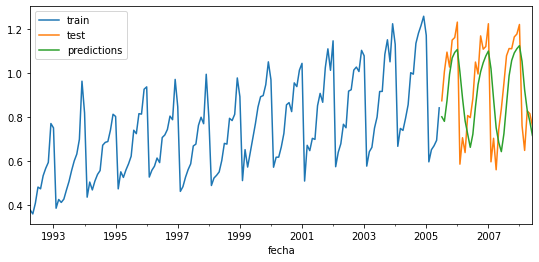

In [19]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [20]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


lo

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3 20] 
  params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.041572,5,50
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.042374,10,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.047357,5,100
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.047655,10,100
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.049627,10,100
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.050294,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.051669,5,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.052149,5,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.052404,5,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.052786,10,50


# Unit Testing

In [21]:
# Unit test __init__
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

def test_init_lags_when_integer():
    '''
    Test creation of attribute lags when integer is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=10)
    assert (forecaster.lags == np.arange(10) + 1).all()
    
def test_init_lags_when_list():
    '''
    Test creation of attribute lags when list is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=[1, 2, 3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    
def test_init_lags_when_range():
    '''
    Test creation of attribute lags when range is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=range(1, 4))
    assert (forecaster.lags == np.array(range(1, 4))).all()
    
def test_init_lags_when_numpy_arange():
    '''
    Test creation of attribute lags when numpy arange is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=np.arange(1, 10))
    assert (forecaster.lags == np.arange(1, 10)).all()

def test_init_exception_when_lags_is_int_lower_than_1():
    '''
    Test exception is raised when lags is initialized with int lower than 1.
    '''
    with pytest.raises(Exception):
        ForecasterAutoreg(LinearRegression(), lags=-10)
        
def test_init_exception_when_lags_has_values_lower_than_1():
    '''
    Test exception is raised when lags is initialized with any value lower than 1.
    '''
    for lags in [[0, 1], range(0, 2), np.arange(0, 2)]:
        with pytest.raises(Exception):
            ForecasterAutoreg(LinearRegression(), lags=lags)

        
test_init_lags_when_integer()
test_init_lags_when_list() 
test_init_lags_when_range()
test_init_lags_when_numpy_arange()
test_init_exception_when_lags_is_int_lower_than_1()  
test_init_exception_when_lags_has_values_lower_than_1()

In [22]:
# Unit test _create_lags
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_create_lags_output():
    '''
    Test matrix of lags is created properly when langs=3 and y=np.arange(10).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    results = forecaster._create_lags(y=np.arange(10))
    expected = (np.array([[2., 1., 0.],
                         [3., 2., 1.],
                         [4., 3., 2.],
                         [5., 4., 3.],
                         [6., 5., 4.],
                         [7., 6., 5.],
                         [8., 7., 6.]]),
               np.array([3., 4., 5., 6., 7., 8., 9.]))

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()
    
    
def test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag():
    '''
    Test exception is raised when lenght of y is lower than maximum lag included
    in the forecaster.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=10)
    with pytest.raises(Exception):
        forecaster._create_lags(y=np.arange(5))

test_create_lags_output()
test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag()

In [23]:
# Unit test create_train_X_y
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is None.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0],
                                    [5, 4, 3, 2, 1],
                                    [6, 5, 4, 3, 2],
                                    [7, 6, 5, 4, 3],
                                    [8, 7, 6, 5, 4]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )     

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas series
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog =  pd.Series(np.arange(100, 110), name='exog')
              )
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105],
                                    [5, 4, 3, 2, 1, 106],
                                    [6, 5, 4, 3, 2, 107],
                                    [7, 6, 5, 4, 3, 108],
                                    [8, 7, 6, 5, 4, 109]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )       

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_daraframe():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas dataframe with two columns.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog = pd.DataFrame({
                            'exog_1' : np.arange(100, 110),
                            'exog_2' : np.arange(1000, 1010)
                })
              )
        
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105, 1005],
                                  [5, 4, 3, 2, 1, 106, 1006],
                                  [6, 5, 4, 3, 2, 107, 1007],
                                  [7, 6, 5, 4, 3, 108, 1008],
                                  [8, 7, 6, 5, 4, 109, 1009]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog_1', 'exog_2']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9])
                )
               )        

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_exception_when_y_and_exog_have_different_lenght():
    '''
    Test exception is raised when lenght of y and lenght of exog are different.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(50)), exog=pd.Series(np.arange(10)))
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(10)), exog=pd.Series(np.arange(50)))
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(10)),
            exog=pd.DataFrame(np.arange(50).reshape(25,2))
        )
        
def test_create_train_X_y_exception_when_y_and_exog_have_different_index():
    '''
    Test exception is raised when y and exog have diferent index.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(50)),
            exog=pd.Series(np.arange(10), index=np.arange(100, 110))
        )
           
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_daraframe()
test_create_train_X_y_exception_when_y_and_exog_have_different_lenght()

/home/ximo/Documents/GitHub/skforecast/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '
/home/ximo/Documents/GitHub/skforecast/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '


In [24]:
# Unit test fit
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

        
def test_fit_last_window_stored():
    '''
    Test that values of last window are stored after fitting.
    '''    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    expected = pd.Series(np.array([47, 48, 49]), index=[47, 48, 49])
    assert (forecaster.last_window == expected).all()
    
    
def test_fit_in_sample_residuals_stored():
    '''
    Test that values of in_sample_residuals are stored after fitting.
    '''    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = np.array([0, 0])
    results = forecaster.in_sample_residuals  
    assert results.values == approx(expected)
    
test_fit_last_window_stored()
test_fit_in_sample_residuals_stored()

In [25]:
# Unit test _recursive_predict
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

def test_recursive_predict_output_when_regresor_is_LinearRegression():
    '''
    Test _recursive_predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster._recursive_predict(
                    steps = 5,
                    last_window = forecaster.last_window.values,
                    exog = None
                  )
    expected = np.array([50., 51., 52., 53., 54.])
    assert (predictions == approx(expected))
    
test_recursive_predict_output_when_regresor_is_LinearRegression()

In [26]:
# Unit test predict
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

        
def test_predict_output_when_regresor_is_LinearRegression():
    '''
    Test predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster.predict(steps=5)
    expected = pd.Series(
                data = np.array([50., 51., 52., 53., 54.]),
                index = pd.RangeIndex(start=50, stop=55, step=1),
                name = 'pred'
               )
    pd.testing.assert_series_equal(predictions, expected)
    
test_predict_output_when_regresor_is_LinearRegression()

In [27]:
# Unit test get_coef
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


def test_output_get_coef_when_regressor_is_LinearRegression():
    '''
    Test output of get_coef when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'coef': np.array([0.33333333, 0.33333333, 0.33333333])
                })
    results = forecaster.get_coef()
    assert (results['feature'] == expected['feature']).all()
    assert results['coef'].values == approx(expected['coef'].values)
    
def test_output_get_coef_when_regressor_is_RandomForest():
    '''
    '''
    forecaster = ForecasterAutoreg(RandomForestRegressor(n_estimators=1, max_depth=2), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_coef()
    assert results is expected
    
test_output_get_coef_when_regressor_is_LinearRegression()
test_output_get_coef_when_regressor_is_RandomForest()

/home/ximo/Documents/GitHub/skforecast/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:897: UserWarning: `get_coef` only valid for forecasters with regressor of type (<class 'sklearn.linear_model._base.LinearRegression'>, <class 'sklearn.linear_model._coordinate_descent.Lasso'>, <class 'sklearn.linear_model._ridge.Ridge'>).
  f"`get_coef` only valid for forecasters with "


In [28]:
# Unit test get_feature_importance
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

def test_output_get_feature_importance_when_regressor_is_RandomForest():
    forecaster = ForecasterAutoreg(RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'importance': np.array([0.94766355, 0., 0.05233645])
                })
    results = forecaster.get_feature_importance()
    assert (results['feature'] == expected['feature']).all()
    assert results['importance'].values == approx(expected['importance'].values)
    
    
def test_output_get_feature_importance_when_regressor_is_linear_model():
    forecaster = ForecasterAutoreg(Lasso(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_feature_importance()
    assert results is expected
    
test_output_get_feature_importance_when_regressor_is_RandomForest()
test_output_get_feature_importance_when_regressor_is_linear_model()

/home/ximo/Documents/GitHub/skforecast/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:938: UserWarning: `get_feature_importance` only valid for forecasters with regressor of type (<class 'sklearn.ensemble._forest.RandomForestRegressor'>, <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>).
  f"`get_feature_importance` only valid for forecasters with "


In [29]:
# Unit test set_lags
# ==============================================================================
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_lags_exception_when_lags_argument_is_int_lower_than_1():
    '''
    Test exception is raised when lags argument is lower than 1.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=-10)

def test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1():
    '''
    Test exception is raised when lags argument has at least one value
    lower than 1.
    '''
    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=range(0, 4))        
        
def test_set_lags_when_lags_argument_is_int():
    '''
    Test how lags and max_lag attributes change when lags argument is integer
    positive (5).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=5)
    assert (forecaster.lags == np.array([1, 2, 3, 4, 5])).all()
    assert forecaster.max_lag == 5
    
def test_set_lags_when_lags_argument_is_list():
    '''
    Test how lags and max_lag attributes change when lags argument is a list
    of positive integers.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=[1,2,3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
def test_set_lags_when_lags_argument_is_1d_numpy_array():
    '''
    Test how lags and max_lag attributes change when lags argument is 1d numpy
    array of positive integers.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=np.array([1,2,3]))
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
test_set_lags_exception_when_lags_argument_is_int_lower_than_1()
test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1()
test_set_lags_when_lags_argument_is_int()
test_set_lags_when_lags_argument_is_list()
test_set_lags_when_lags_argument_is_1d_numpy_array()

In [30]:
# Unit test set_params
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_params():
    
    forecaster = ForecasterAutoreg(LinearRegression(fit_intercept=True), lags=3)
    new_paramns = {'fit_intercept': False}
    forecaster.set_params(**new_paramns)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_params()

In [31]:
# Unit test set_out_sample_residuals
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_out_sample_residuals_exception_when_residuals_is_not_array():
    '''
    Test exception is raised when residuals argument is not numpy array.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_out_sample_residuals(residuals=[1, 2, 3])
        
        
def test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_no_append():
    '''
    Test residuals stored when its length is less than 1000 and append is False.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=False)
    expected = np.arange(10)
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    
def test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_append():
    '''
    Test residuals stored when its length is less than 1000 and append is True.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    expected = np.hstack([np.arange(10), np.arange(10)])
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    

def test_set_out_sample_residuals_when_residuals_lenght_is_greater_than_1000():
    '''
    Test residuals stored when its length is greater than 1000.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(2000))
    assert len(forecaster.out_sample_residuals) == 1000

test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_no_append()
test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_append()
test_set_out_sample_residuals_when_residuals_lenght_is_greater_than_1000()

In [32]:
# Unit test set_out_sample_residuals
# ==============================================================================
from pytest import approx
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=True)  
    pd.testing.assert_frame_equal(results, expected)

    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10. ,20., 20.],
                             [11., 24.33333333, 24.33333333]
                            ]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=True)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10. ,20., 20.],
                             [11., 24.33333333, 24.33333333]
                            ]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)
    

test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [33]:
# Unit test _estimate_boot_interval
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
        

def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=True)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    2 steps are predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.],
                        [24.33333333, 24.33333333]])
    results = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=True)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using out-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=False)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    2 steps are predicted using out-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20.        , 20.        ],
                        [24.33333333, 24.33333333]])
    results = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=False)  
    assert results == approx(expected)
    
    
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [34]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
matplotlib          3.4.3
numpy               1.19.5
pandas              1.2.5
pytest              6.2.4
session_info        1.0.0
skforecast          0.4.0
sklearn             1.0.1
-----
IPython             7.26.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-41-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-12-08 22:24
